[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/nipunbatra/ml-teaching/blob/master/notebooks/pr-curve.ipynb)

# Precision-Recall and ROC Curves: A Comprehensive Guide

This notebook provides a comprehensive tutorial on:
- Precision-Recall (PR) curves
- Receiver Operating Characteristic (ROC) curves  
- AUC-PR and AUC-ROC metrics
- When to use each metric
- Comparing multiple classifiers

We'll use the same synthetic dataset and compare 3 different classifiers.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina'

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

## 1. Dataset Creation

We'll create a synthetic binary classification dataset using `make_blobs()`:

In [3]:
from sklearn.datasets import make_blobs
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Create dataset
X, y = make_blobs(n_samples=100, centers=2, n_features=2, random_state=42, cluster_std=8.0)

# Split into train and test
train_samples = 40
X_train = X[:train_samples]
y_train = y[:train_samples]

X_test = X[train_samples:]
y_test = y[train_samples:]

print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")
print(f"Class distribution in train: Class 0: {(y_train==0).sum()}, Class 1: {(y_train==1).sum()}")
print(f"Class distribution in test: Class 0: {(y_test==0).sum()}, Class 1: {(y_test==1).sum()}")

Training samples: 40
Test samples: 60
Class distribution in train: Class 0: 19, Class 1: 21
Class distribution in test: Class 0: 31, Class 1: 29


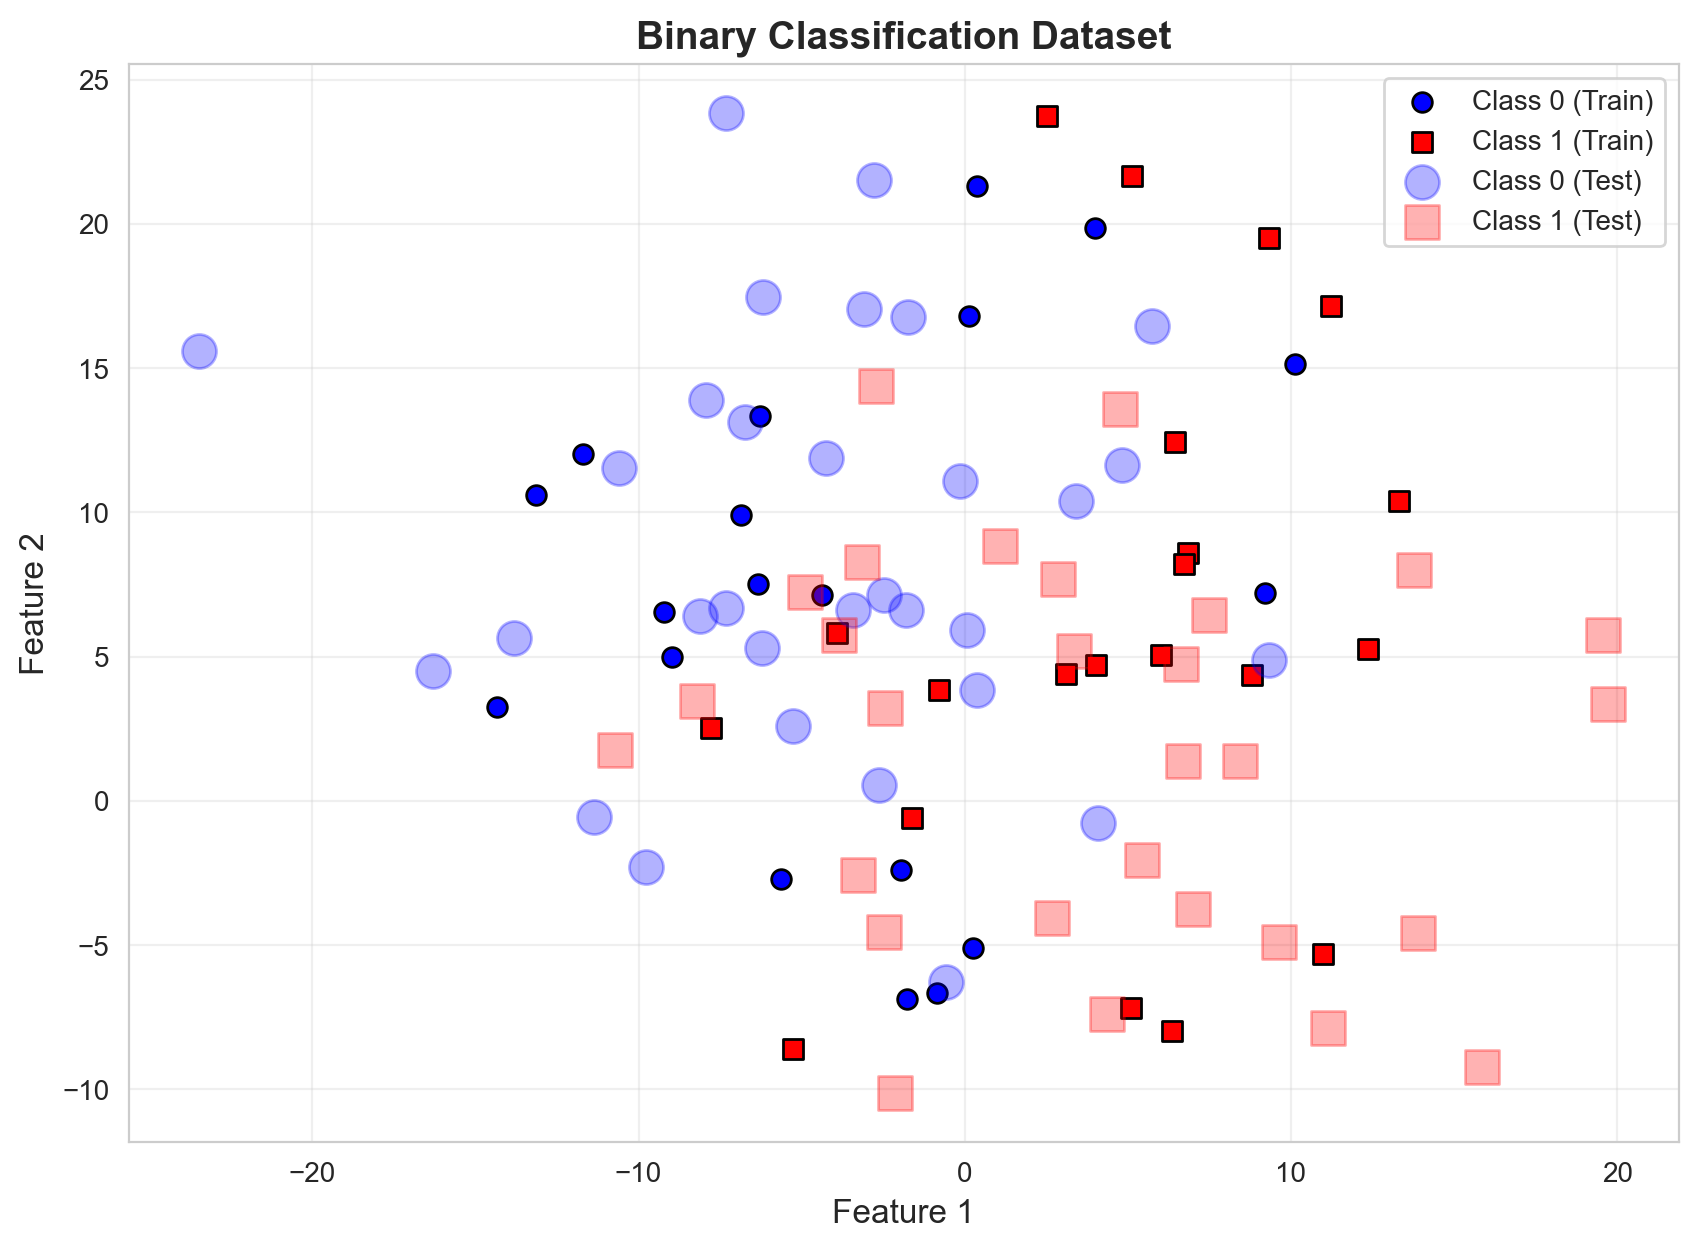

In [4]:
# Visualize the dataset
plt.figure(figsize=(10, 7))

# Plot training data with small markers
plt.scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1], 
           marker='o', label='Class 0 (Train)', color='blue', s=50, edgecolors='k')
plt.scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1], 
           marker='s', label='Class 1 (Train)', color='red', s=50, edgecolors='k')

# Plot test data with larger, transparent markers
plt.scatter(X_test[y_test == 0, 0], X_test[y_test == 0, 1], 
           marker='o', s=150, label='Class 0 (Test)', color='blue', alpha=0.3)
plt.scatter(X_test[y_test == 1, 0], X_test[y_test == 1, 1], 
           marker='s', s=150, label='Class 1 (Test)', color='red', alpha=0.3)

plt.xlabel('Feature 1', fontsize=12)
plt.ylabel('Feature 2', fontsize=12)
plt.title('Binary Classification Dataset', fontsize=14, fontweight='bold')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.show()

## 2. Train Multiple Classifiers

We'll train 3 different classifiers to compare their performance:
1. **Logistic Regression** - Linear decision boundary
2. **Random Forest** - Non-linear, ensemble method
3. **Support Vector Machine (SVM)** - With RBF kernel

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Train Logistic Regression
lr = LogisticRegression(penalty=None, max_iter=1000, random_state=42)
lr.fit(X_train, y_train)

# Train Random Forest
rf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
rf.fit(X_train, y_train)

# Train SVM with probability estimates
svm = SVC(kernel='rbf', probability=True, random_state=42)
svm.fit(X_train, y_train)

# Store models in a dictionary for easy iteration
models = {
    'Logistic Regression': lr,
    'Random Forest': rf,
    'SVM (RBF)': svm
}

print("All models trained successfully!")

All models trained successfully!


### Basic Accuracy Comparison

In [6]:
# Compare basic accuracy
print("Model Accuracy Comparison:")
print("=" * 50)
for name, model in models.items():
    acc = accuracy_score(y_test, model.predict(X_test))
    print(f"{name:25s}: {acc:.3f}")

Model Accuracy Comparison:
Logistic Regression      : 0.733
Random Forest            : 0.717
SVM (RBF)                : 0.717


## 3. Understanding Confusion Matrix and Metrics

Let's create a helper function to compute precision, recall, and other metrics from the confusion matrix.

In [7]:
def confusion_metrics(model, X, y, threshold=0.5, eps=1e-8, show_matrix=False):
    """
    Compute confusion matrix and derived metrics.
    
    Returns: precision, recall, specificity, fpr, tpr
    """
    pred_prob = model.predict_proba(X)
    pred = (pred_prob[:, 1] >= threshold).astype(int)
    
    # Compute confusion matrix components
    TP = ((y == 1) & (pred == 1)).sum()
    TN = ((y == 0) & (pred == 0)).sum()
    FP = ((y == 0) & (pred == 1)).sum()
    FN = ((y == 1) & (pred == 0)).sum()
    
    # Compute metrics
    precision = TP / (TP + FP + eps)
    recall = TP / (TP + FN + eps)  # Also called TPR (True Positive Rate)
    specificity = TN / (TN + FP + eps)  # True Negative Rate
    fpr = FP / (FP + TN + eps)  # False Positive Rate = 1 - specificity
    
    if show_matrix:
        cm = confusion_matrix(y, pred)
        print("\nConfusion Matrix:")
        print(pd.DataFrame(cm, 
                          index=['Actual Negative', 'Actual Positive'], 
                          columns=['Predicted Negative', 'Predicted Positive']))
        print(f"\nTP={TP}, FP={FP}, TN={TN}, FN={FN}")
        print(f"Precision: {precision:.3f}")
        print(f"Recall (TPR): {recall:.3f}")
        print(f"Specificity (TNR): {specificity:.3f}")
        print(f"FPR: {fpr:.3f}")
    
    return precision, recall, specificity, fpr

# Test with Logistic Regression at default threshold
confusion_metrics(lr, X_test, y_test, threshold=0.5, show_matrix=True)


Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative                  24                   7
Actual Positive                   9                  20

TP=20, FP=7, TN=24, FN=9
Precision: 0.741
Recall (TPR): 0.690
Specificity (TNR): 0.774
FPR: 0.226


(np.float64(0.7407407404663923),
 np.float64(0.6896551721759809),
 np.float64(0.7741935481373569),
 np.float64(0.22580645154006243))

## 4. Precision-Recall Analysis

### Threshold Sweep for Logistic Regression

In [8]:
print("Threshold Analysis for Logistic Regression")
print("=" * 70)
print(f"{'Threshold':>10s} {'Precision':>12s} {'Recall':>10s} {'Specificity':>12s} {'FPR':>10s}")
print("=" * 70)

for threshold in np.linspace(0, 1, 21):
    precision, recall, specificity, fpr = confusion_metrics(lr, X_test, y_test, threshold)
    print(f"{threshold:10.2f} {precision:12.3f} {recall:10.3f} {specificity:12.3f} {fpr:10.3f}")

Threshold Analysis for Logistic Regression
 Threshold    Precision     Recall  Specificity        FPR
      0.00        0.483      1.000        0.000      1.000
      0.05        0.509      1.000        0.097      0.903
      0.10        0.527      1.000        0.161      0.839
      0.15        0.583      0.966        0.355      0.645
      0.20        0.587      0.931        0.387      0.613
      0.25        0.634      0.897        0.516      0.484
      0.30        0.649      0.828        0.581      0.419
      0.35        0.657      0.793        0.613      0.387
      0.40        0.687      0.759        0.677      0.323
      0.45        0.724      0.724        0.742      0.258
      0.50        0.741      0.690        0.774      0.226
      0.55        0.760      0.655        0.806      0.194
      0.60        0.783      0.621        0.839      0.161
      0.65        0.810      0.586        0.871      0.129
      0.70        0.882      0.517        0.935      0.065
      0.75   

### Visualize Precision and Recall vs Threshold

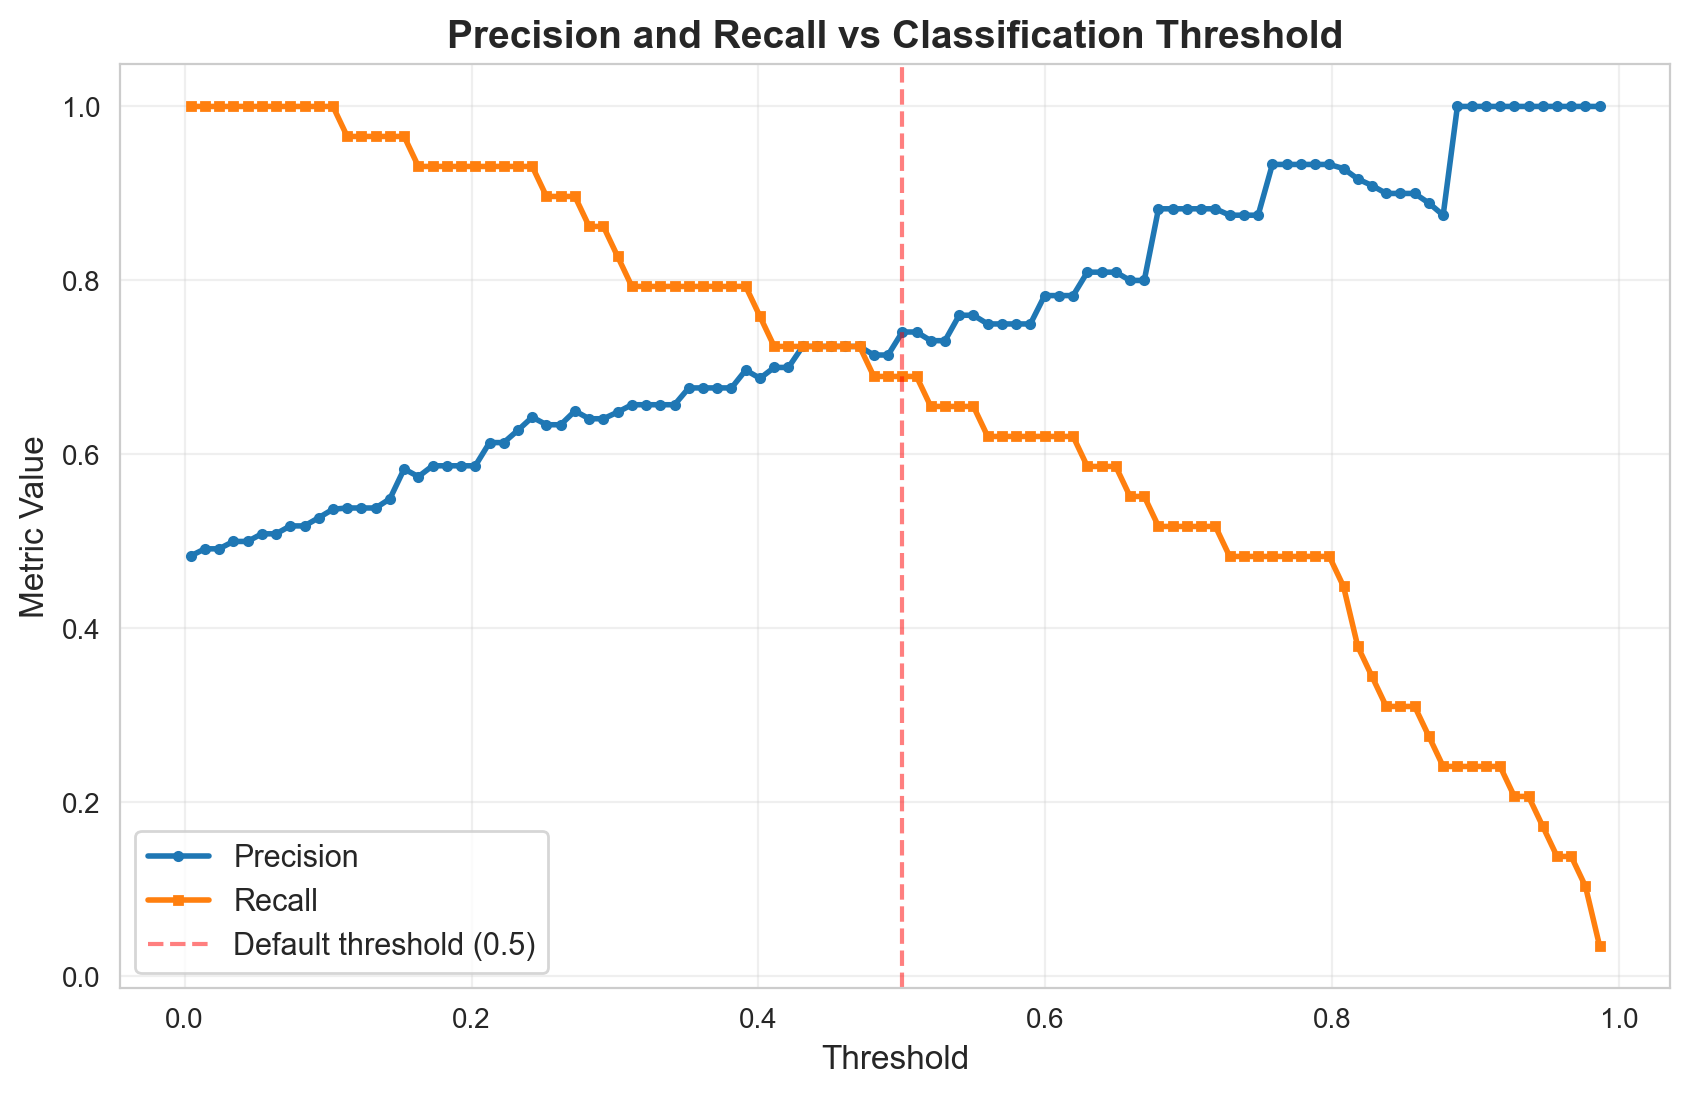

In [9]:
# Compute precision and recall across thresholds
min_prob = lr.predict_proba(X_test)[:, 1].min()
max_prob = lr.predict_proba(X_test)[:, 1].max()
thresholds = np.linspace(min_prob, max_prob, 100)

precisions = []
recalls = []

for threshold in thresholds:
    precision, recall, _, _ = confusion_metrics(lr, X_test, y_test, threshold)
    precisions.append(precision)
    recalls.append(recall)

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(thresholds, precisions, label='Precision', linewidth=2, marker='o', markersize=3)
ax.plot(thresholds, recalls, label='Recall', linewidth=2, marker='s', markersize=3)
ax.axvline(x=0.5, color='red', linestyle='--', alpha=0.5, label='Default threshold (0.5)')
ax.set_xlabel('Threshold', fontsize=12)
ax.set_ylabel('Metric Value', fontsize=12)
ax.set_title('Precision and Recall vs Classification Threshold', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.show()

### Precision-Recall Curve

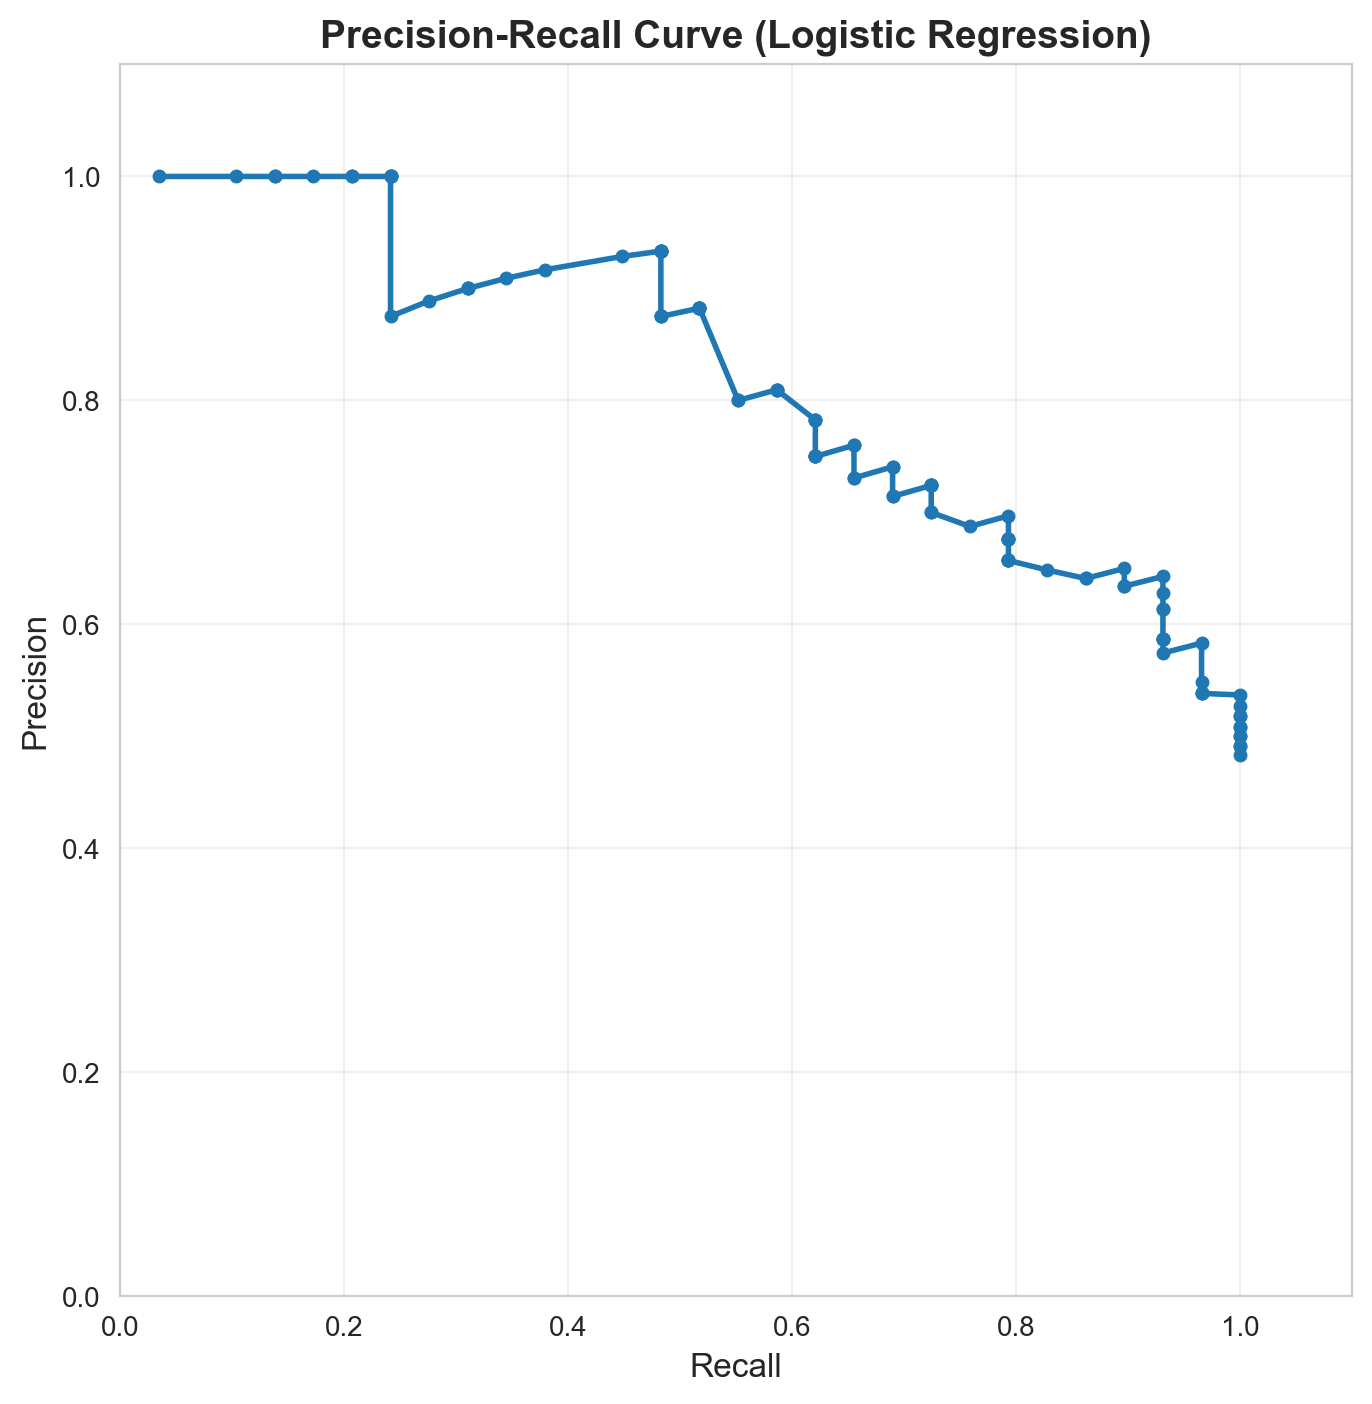

In [10]:
# Manual PR curve
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(recalls, precisions, marker='o', linewidth=2, markersize=4)
ax.set_xlabel('Recall', fontsize=12)
ax.set_ylabel('Precision', fontsize=12)
ax.set_title('Precision-Recall Curve (Logistic Regression)', fontsize=14, fontweight='bold')
ax.set_xlim([0, 1.1])
ax.set_ylim([0, 1.1])
ax.set_aspect('equal')
ax.grid(True, alpha=0.3)
plt.show()

## 5. ROC Curves: Receiver Operating Characteristic

### What is ROC?

ROC stands for **Receiver Operating Characteristic**. It was developed during World War II for analyzing radar signals.

- **R**eceiver: The detector/classifier receiving signals
- **O**perating: Different operating points (thresholds)
- **C**haracteristic: Performance characteristics at each threshold

**ROC Curve plots:**
- **X-axis**: False Positive Rate (FPR) = FP / (FP + TN)
- **Y-axis**: True Positive Rate (TPR) = TP / (TP + FN) = Recall

### Intuitive Understanding:

- **TPR (Recall)**: Of all actual positives, how many did we catch?
- **FPR**: Of all actual negatives, how many did we incorrectly flag as positive?

**Ideal ROC curve**: Hugs the top-left corner (TPR=1, FPR=0)
**Random classifier**: Diagonal line from (0,0) to (1,1)

### Compute TPR and FPR for Logistic Regression

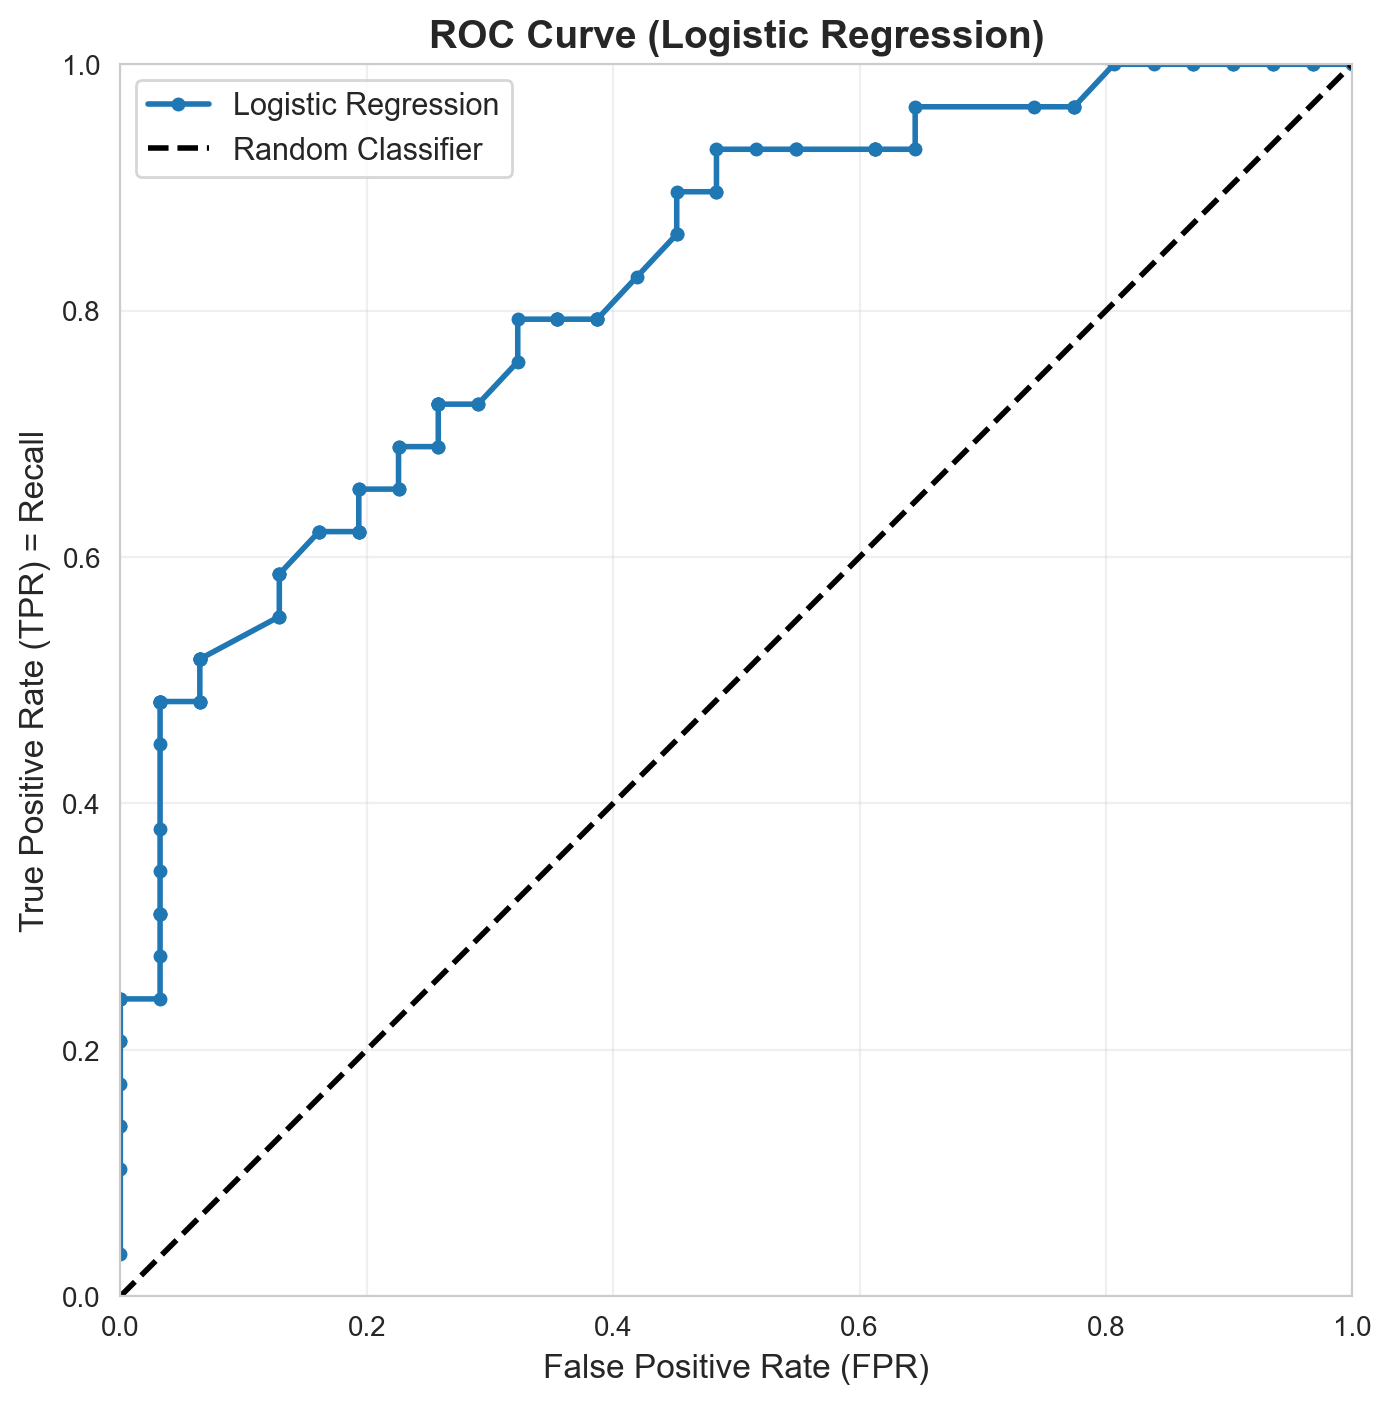

In [11]:
# Compute TPR and FPR across thresholds
tprs = []
fprs = []

for threshold in thresholds:
    _, recall, _, fpr = confusion_metrics(lr, X_test, y_test, threshold)
    tprs.append(recall)  # TPR = Recall
    fprs.append(fpr)

# Plot ROC curve
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(fprs, tprs, marker='o', linewidth=2, markersize=4, label='Logistic Regression')
ax.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Classifier')
ax.set_xlabel('False Positive Rate (FPR)', fontsize=12)
ax.set_ylabel('True Positive Rate (TPR) = Recall', fontsize=12)
ax.set_title('ROC Curve (Logistic Regression)', fontsize=14, fontweight='bold')
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_aspect('equal')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.show()

## 6. AUC: Area Under the Curve

### AUC-PR and AUC-ROC for All Models

Let's compute both AUC metrics for all three classifiers:

In [12]:
from sklearn.metrics import (
    roc_curve, auc, roc_auc_score,
    precision_recall_curve, average_precision_score,
    RocCurveDisplay, PrecisionRecallDisplay
)

# Compute AUC scores for all models
auc_results = []

for name, model in models.items():
    y_scores = model.predict_proba(X_test)[:, 1]
    
    # AUC-ROC
    auc_roc = roc_auc_score(y_test, y_scores)
    
    # AUC-PR (Average Precision)
    auc_pr = average_precision_score(y_test, y_scores)
    
    auc_results.append({
        'Model': name,
        'AUC-ROC': auc_roc,
        'AUC-PR': auc_pr
    })

# Display as DataFrame
auc_df = pd.DataFrame(auc_results)
auc_df = auc_df.sort_values('AUC-ROC', ascending=False).reset_index(drop=True)
print("\n" + "=" * 60)
print("AUC Score Comparison")
print("=" * 60)
print(auc_df.to_string(index=False))
print("=" * 60)


AUC Score Comparison
              Model  AUC-ROC   AUC-PR
Logistic Regression 0.819800 0.828924
      Random Forest 0.789210 0.804978
          SVM (RBF) 0.765295 0.749763


## 7. Visual Comparison: PR Curves for All Models

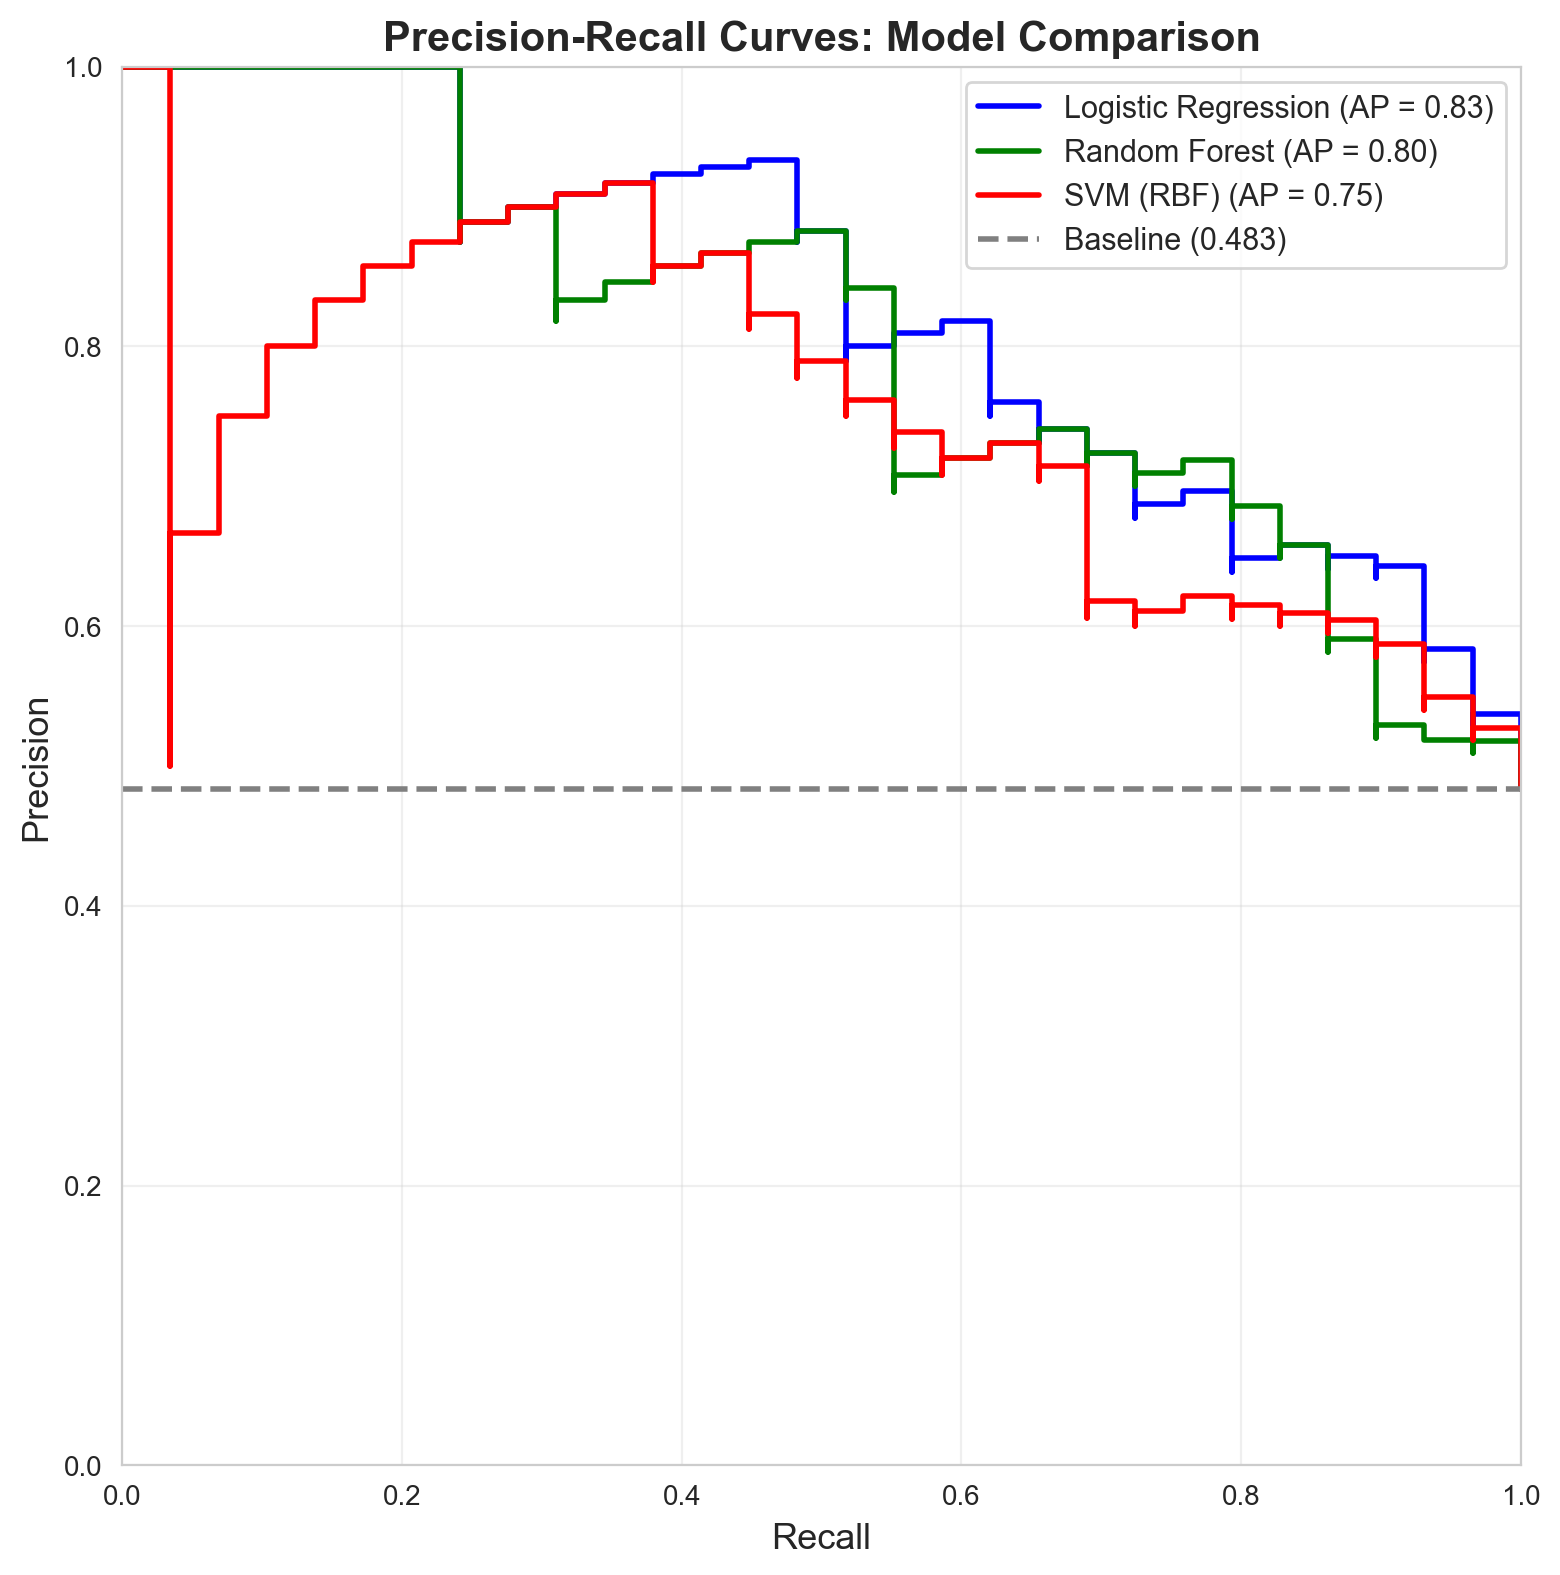

In [13]:
fig, ax = plt.subplots(figsize=(10, 8))

colors = ['blue', 'green', 'red']
for (name, model), color in zip(models.items(), colors):
    display = PrecisionRecallDisplay.from_estimator(
        model, X_test, y_test, 
        name=name,
        ax=ax,
        color=color,
        linewidth=2
    )

# Add chance level (baseline)
chance_level = (y_test == 1).sum() / len(y_test)
ax.axhline(y=chance_level, color='gray', linestyle='--', 
          linewidth=2, label=f'Baseline ({chance_level:.3f})')

ax.set_xlabel('Recall', fontsize=13)
ax.set_ylabel('Precision', fontsize=13)
ax.set_title('Precision-Recall Curves: Model Comparison', 
            fontsize=15, fontweight='bold')
ax.legend(loc='best', fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
plt.tight_layout()
plt.show()

## 8. Visual Comparison: ROC Curves for All Models

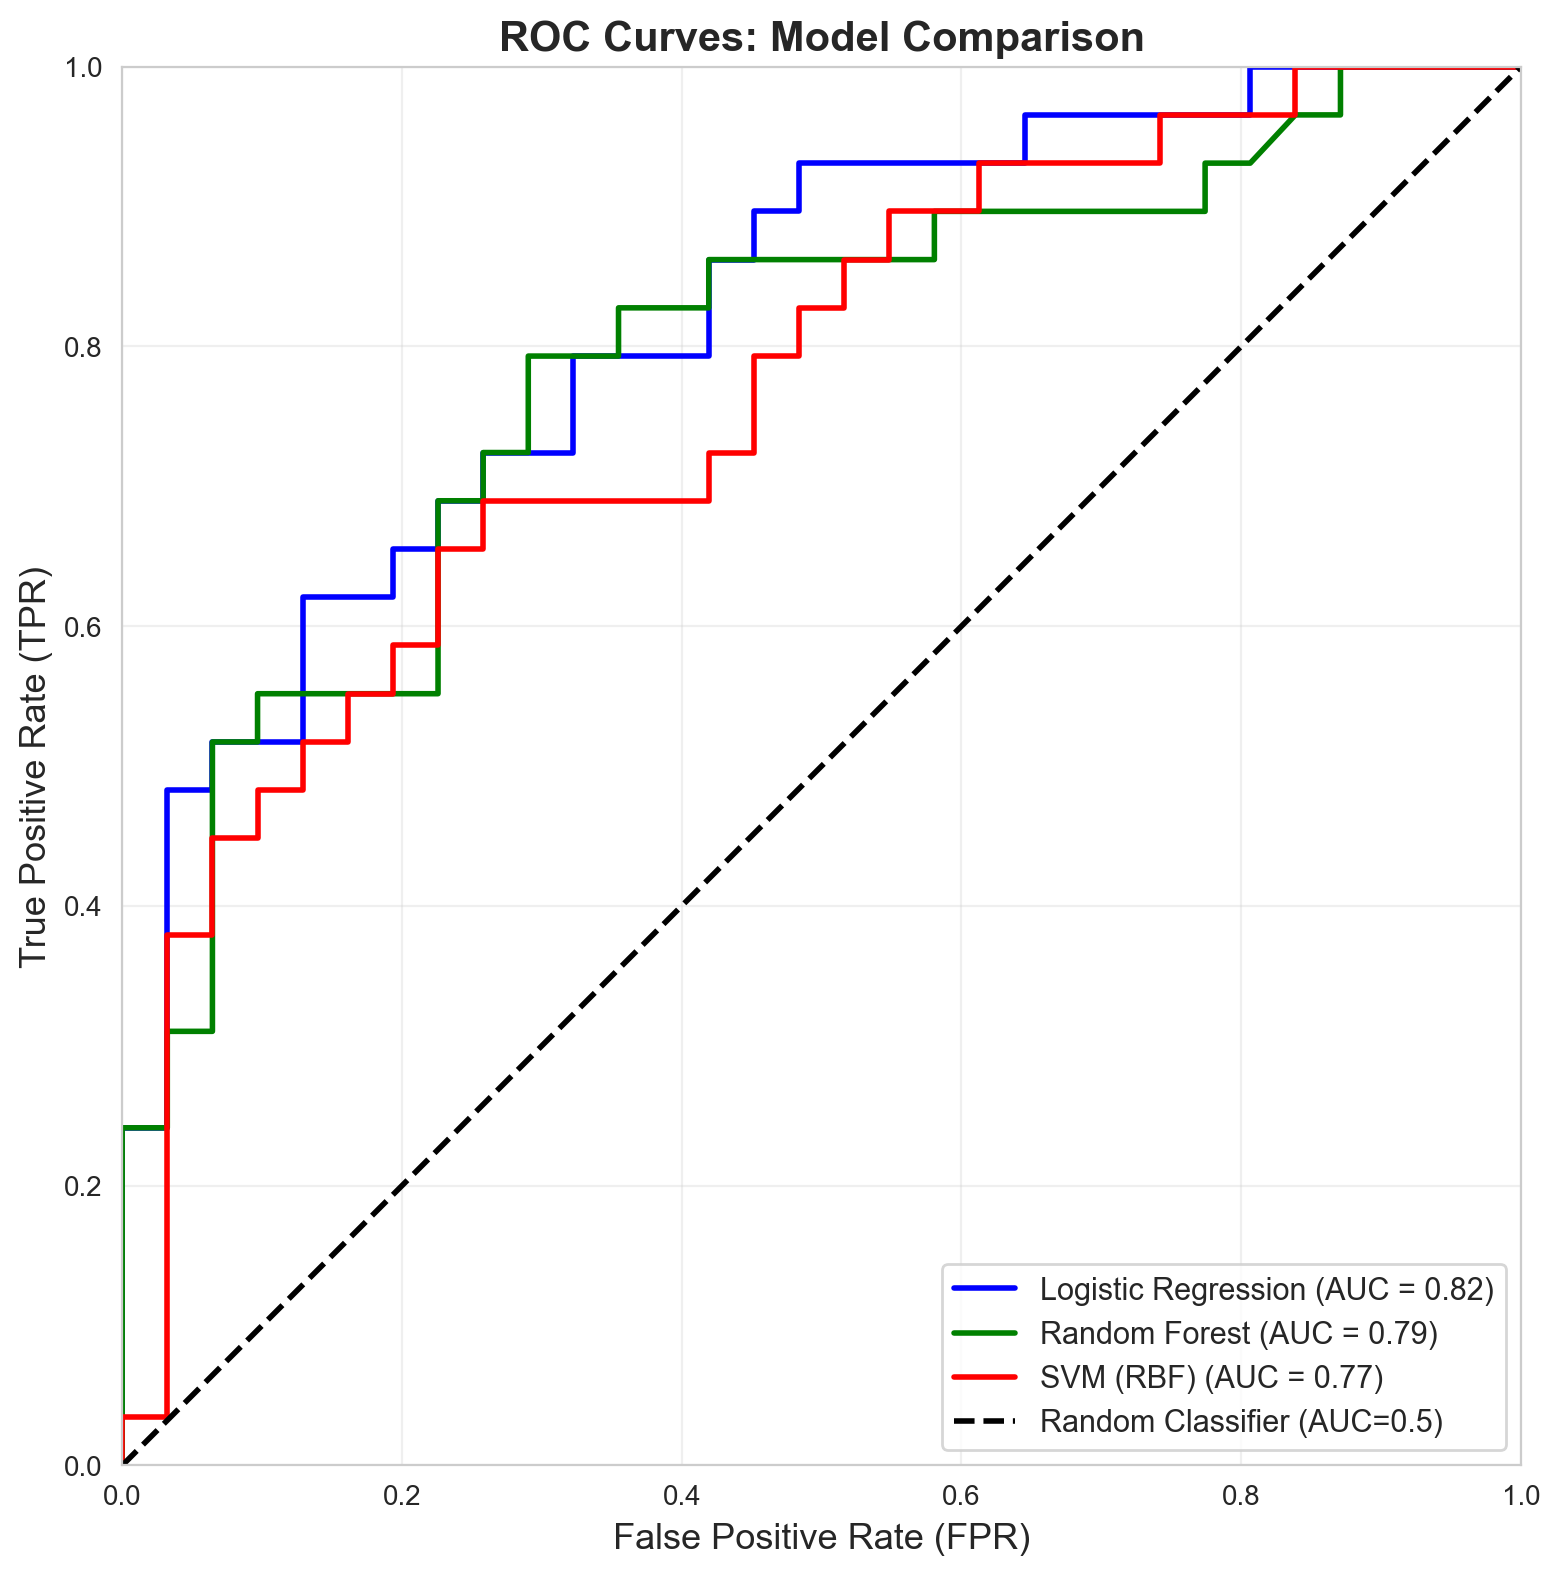

In [14]:
fig, ax = plt.subplots(figsize=(10, 8))

colors = ['blue', 'green', 'red']
for (name, model), color in zip(models.items(), colors):
    display = RocCurveDisplay.from_estimator(
        model, X_test, y_test,
        name=name,
        ax=ax,
        color=color,
        linewidth=2
    )

# Add diagonal (random classifier)
ax.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Classifier (AUC=0.5)')

ax.set_xlabel('False Positive Rate (FPR)', fontsize=13)
ax.set_ylabel('True Positive Rate (TPR)', fontsize=13)
ax.set_title('ROC Curves: Model Comparison', 
            fontsize=15, fontweight='bold')
ax.legend(loc='lower right', fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_aspect('equal')
plt.tight_layout()
plt.show()

## 9. Side-by-Side Comparison: PR vs ROC

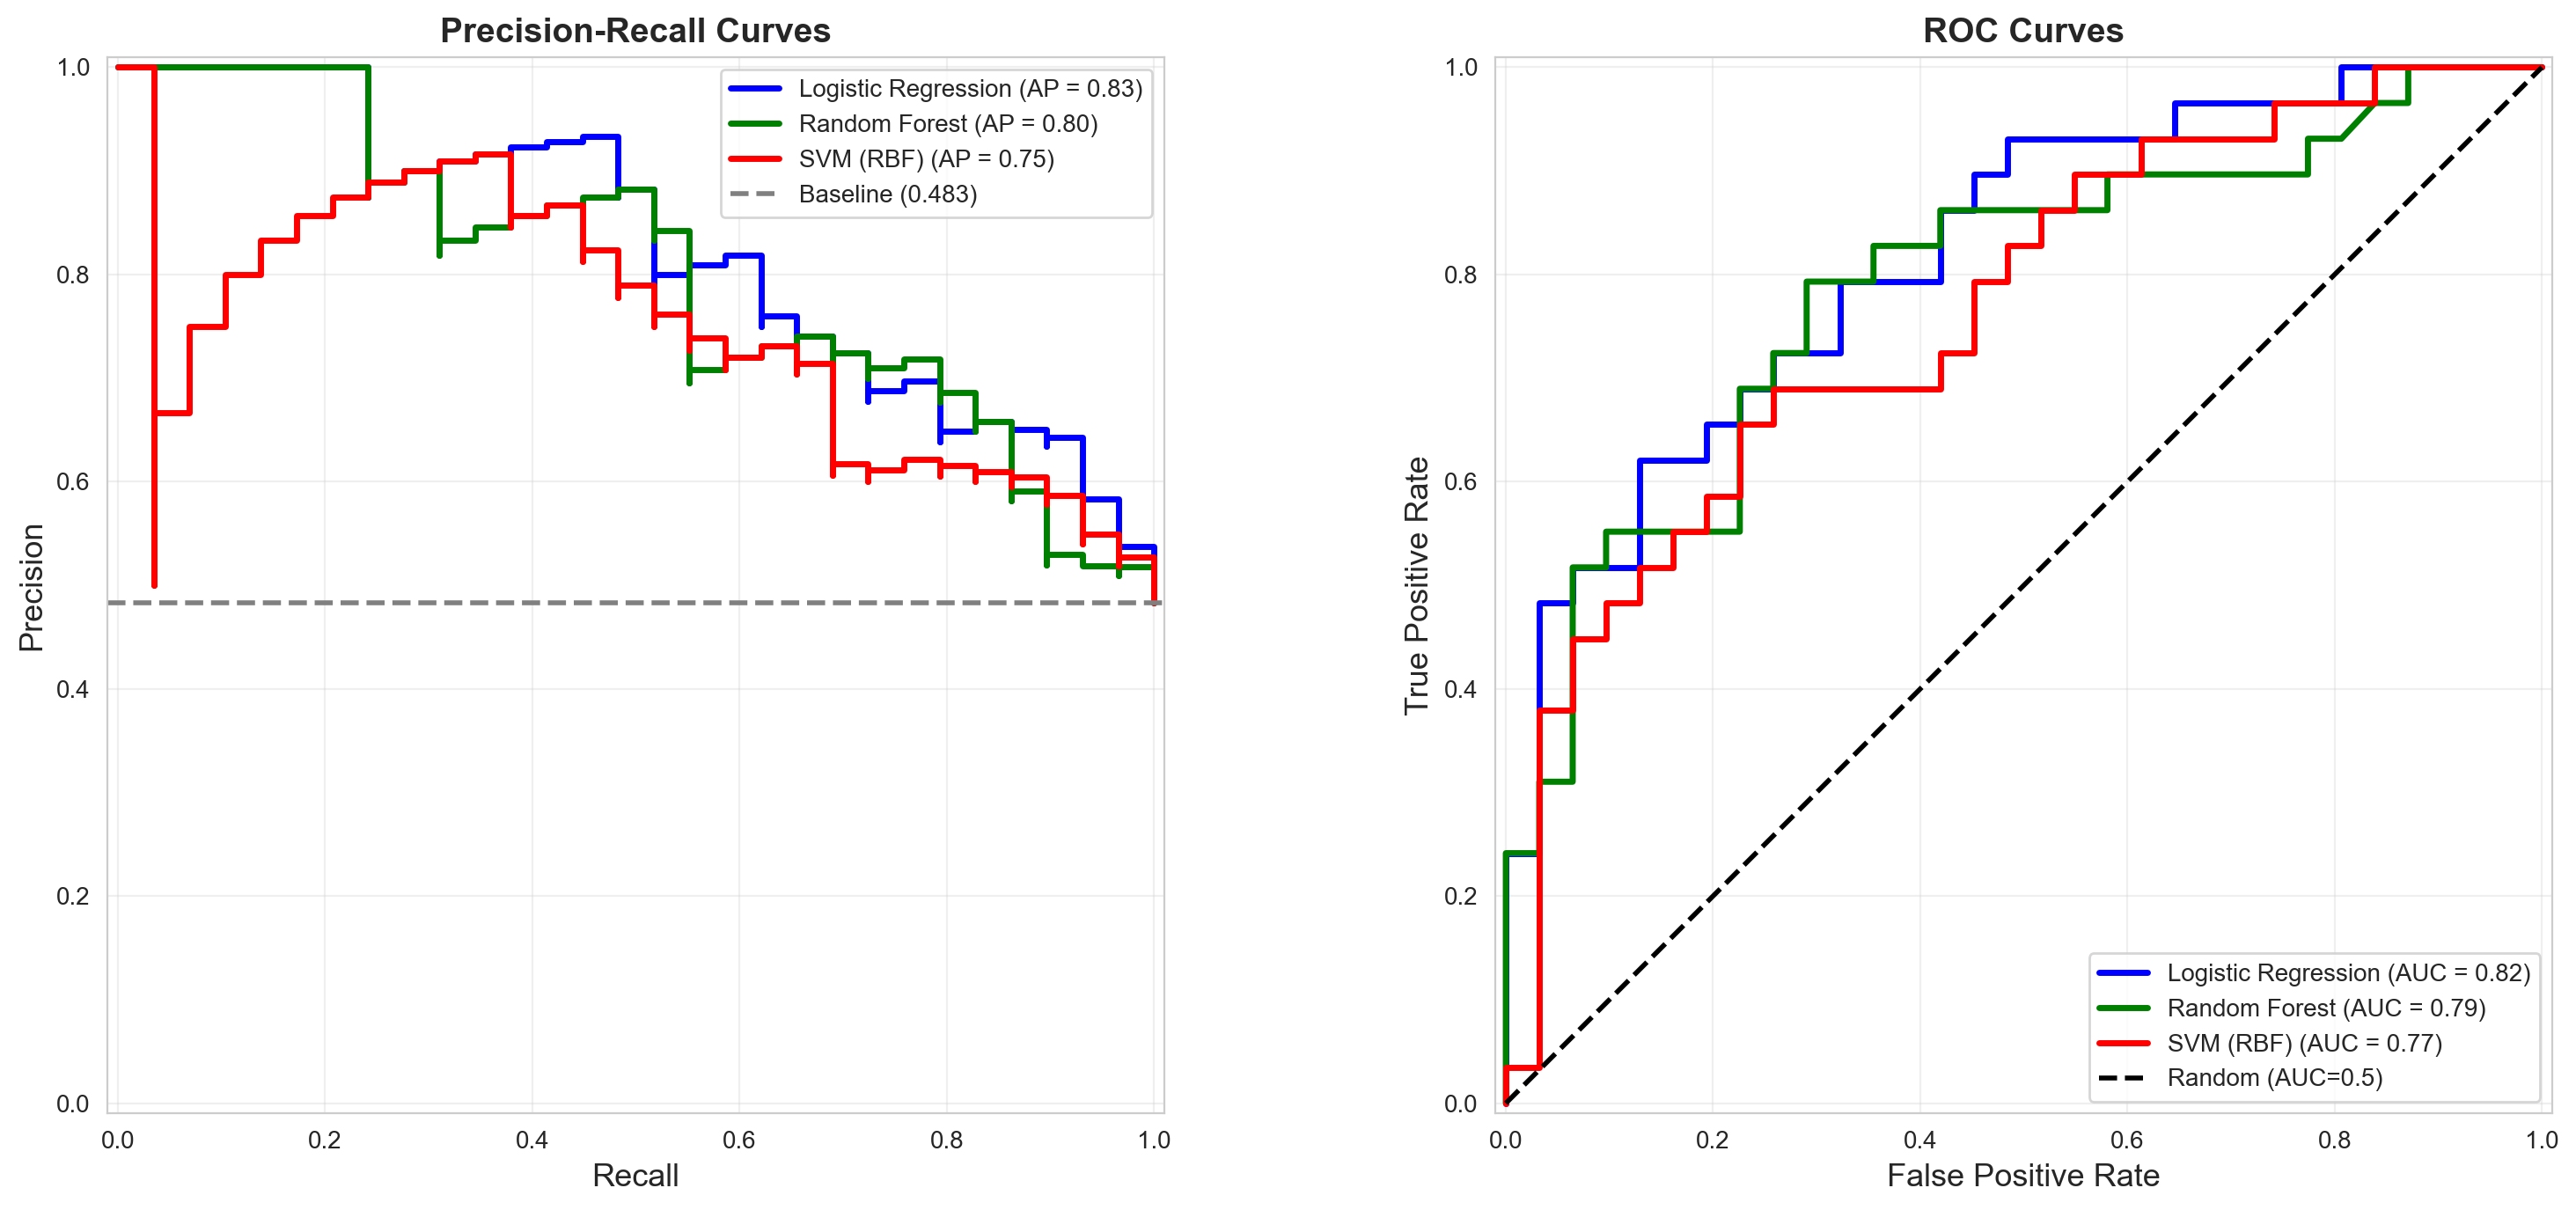

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# PR Curves
ax = axes[0]
colors = ['blue', 'green', 'red']
for (name, model), color in zip(models.items(), colors):
    display = PrecisionRecallDisplay.from_estimator(
        model, X_test, y_test, 
        name=name,
        ax=ax,
        color=color,
        linewidth=2.5
    )

chance_level = (y_test == 1).sum() / len(y_test)
ax.axhline(y=chance_level, color='gray', linestyle='--', 
          linewidth=2, label=f'Baseline ({chance_level:.3f})')
ax.set_xlabel('Recall', fontsize=13)
ax.set_ylabel('Precision', fontsize=13)
ax.set_title('Precision-Recall Curves', fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)

# ROC Curves
ax = axes[1]
for (name, model), color in zip(models.items(), colors):
    display = RocCurveDisplay.from_estimator(
        model, X_test, y_test,
        name=name,
        ax=ax,
        color=color,
        linewidth=2.5
    )

ax.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random (AUC=0.5)')
ax.set_xlabel('False Positive Rate', fontsize=13)
ax.set_ylabel('True Positive Rate', fontsize=13)
ax.set_title('ROC Curves', fontsize=14, fontweight='bold')
ax.legend(loc='lower right', fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_aspect('equal')

plt.tight_layout()
plt.show()

## 10. When to Use PR vs ROC?

### Create an Imbalanced Dataset Example

In [16]:
# Create highly imbalanced dataset (5% positive class)
X_imb, y_imb = make_blobs(n_samples=1000, centers=2, n_features=2, 
                          random_state=42, cluster_std=2.5)

# Make it imbalanced: keep only 5% of positive class
pos_indices = np.where(y_imb == 1)[0]
neg_indices = np.where(y_imb == 0)[0]

print(f"Original distribution: Pos={len(pos_indices)}, Neg={len(neg_indices)}")

# Calculate how many samples we can actually get
n_pos = min(50, len(pos_indices))  # 5% of 1000, but not more than available
n_neg = min(950, len(neg_indices))  # 95% of 1000, but not more than available

# Sample from each class
selected_pos = np.random.choice(pos_indices, size=n_pos, replace=False)
selected_neg = np.random.choice(neg_indices, size=n_neg, replace=False)
selected_indices = np.concatenate([selected_pos, selected_neg])

X_imb = X_imb[selected_indices]
y_imb = y_imb[selected_indices]

# Shuffle
np.random.seed(42)
shuffle_idx = np.random.permutation(len(X_imb))
X_imb = X_imb[shuffle_idx]
y_imb = y_imb[shuffle_idx]

# Split
split_point = int(0.7 * len(X_imb))
X_train_imb, X_test_imb = X_imb[:split_point], X_imb[split_point:]
y_train_imb, y_test_imb = y_imb[:split_point], y_imb[split_point:]

print(f"\nImbalanced dataset created:")
print(f"Total samples: {len(X_imb)}")
print(f"Positive class: {(y_imb==1).sum()} ({(y_imb==1).sum()/len(y_imb)*100:.1f}%)")
print(f"Negative class: {(y_imb==0).sum()} ({(y_imb==0).sum()/len(y_imb)*100:.1f}%)")
print(f"\nTest set:")
print(f"Positive: {(y_test_imb==1).sum()}, Negative: {(y_test_imb==0).sum()}")

Original distribution: Pos=500, Neg=500

Imbalanced dataset created:
Total samples: 550
Positive class: 50 (9.1%)
Negative class: 500 (90.9%)

Test set:
Positive: 15, Negative: 150


In [17]:
# Train model on imbalanced data
lr_imb = LogisticRegression(penalty=None, max_iter=1000, random_state=42)
lr_imb.fit(X_train_imb, y_train_imb)

print(f"Model accuracy on imbalanced test set: {accuracy_score(y_test_imb, lr_imb.predict(X_test_imb)):.3f}")

Model accuracy on imbalanced test set: 0.982


### Compare PR and ROC on Imbalanced Data

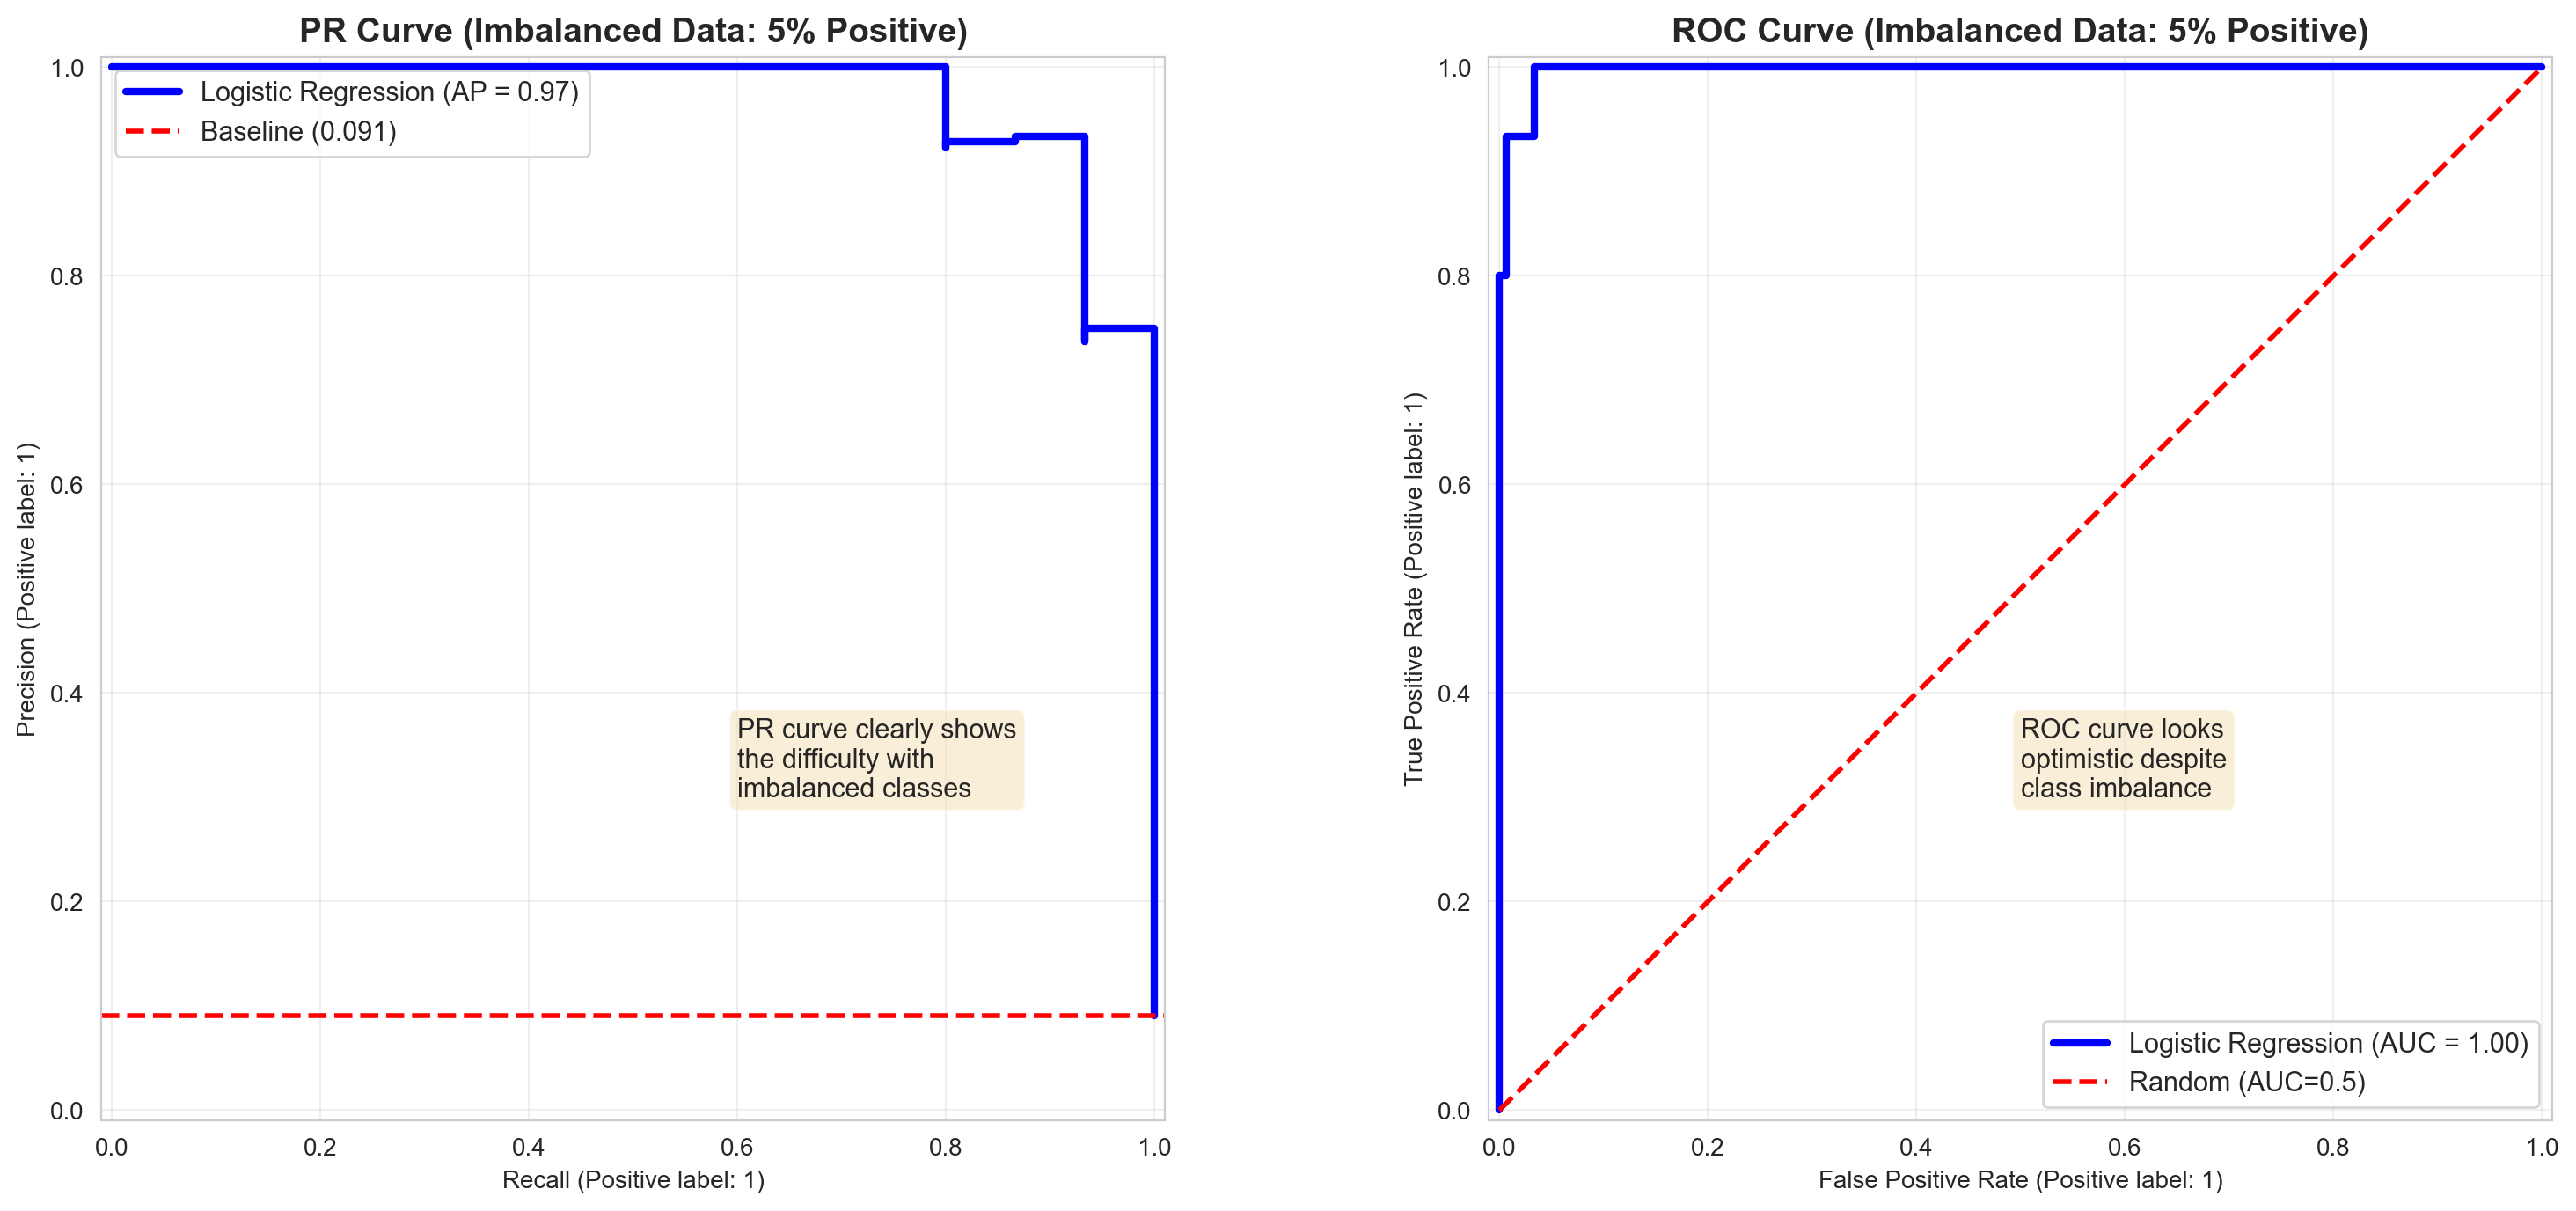

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# PR Curve on imbalanced data
ax = axes[0]
display_pr = PrecisionRecallDisplay.from_estimator(
    lr_imb, X_test_imb, y_test_imb,
    name='Logistic Regression',
    ax=ax,
    color='blue',
    linewidth=3
)
chance_level_imb = (y_test_imb == 1).sum() / len(y_test_imb)
ax.axhline(y=chance_level_imb, color='red', linestyle='--', 
          linewidth=2, label=f'Baseline ({chance_level_imb:.3f})')
ax.set_title('PR Curve (Imbalanced Data: 5% Positive)', 
            fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=11)
ax.grid(True, alpha=0.3)
ax.annotate('PR curve clearly shows\nthe difficulty with\nimbalanced classes', 
           xy=(0.6, 0.3), fontsize=11, 
           bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# ROC Curve on imbalanced data
ax = axes[1]
display_roc = RocCurveDisplay.from_estimator(
    lr_imb, X_test_imb, y_test_imb,
    name='Logistic Regression',
    ax=ax,
    color='blue',
    linewidth=3
)
ax.plot([0, 1], [0, 1], 'r--', linewidth=2, label='Random (AUC=0.5)')
ax.set_title('ROC Curve (Imbalanced Data: 5% Positive)', 
            fontsize=14, fontweight='bold')
ax.legend(loc='lower right', fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_aspect('equal')
ax.annotate('ROC curve looks\noptimistic despite\nclass imbalance', 
           xy=(0.5, 0.3), fontsize=11,
           bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

In [19]:
# Compute AUC scores on imbalanced data
y_scores_imb = lr_imb.predict_proba(X_test_imb)[:, 1]
auc_roc_imb = roc_auc_score(y_test_imb, y_scores_imb)
auc_pr_imb = average_precision_score(y_test_imb, y_scores_imb)

print("\n" + "=" * 60)
print("AUC Scores on Imbalanced Data (5% positive class)")
print("=" * 60)
print(f"AUC-ROC: {auc_roc_imb:.4f}  (looks good!)")
print(f"AUC-PR:  {auc_pr_imb:.4f}  (more realistic for imbalanced data)")
print("=" * 60)
print("\nKey Insight: ROC can be overly optimistic on imbalanced data!")
print("PR curves better reflect the challenge of finding rare positives.")


AUC Scores on Imbalanced Data (5% positive class)
AUC-ROC: 0.9969  (looks good!)
AUC-PR:  0.9741  (more realistic for imbalanced data)

Key Insight: ROC can be overly optimistic on imbalanced data!
PR curves better reflect the challenge of finding rare positives.


## 11. Visualization: Decision Boundaries

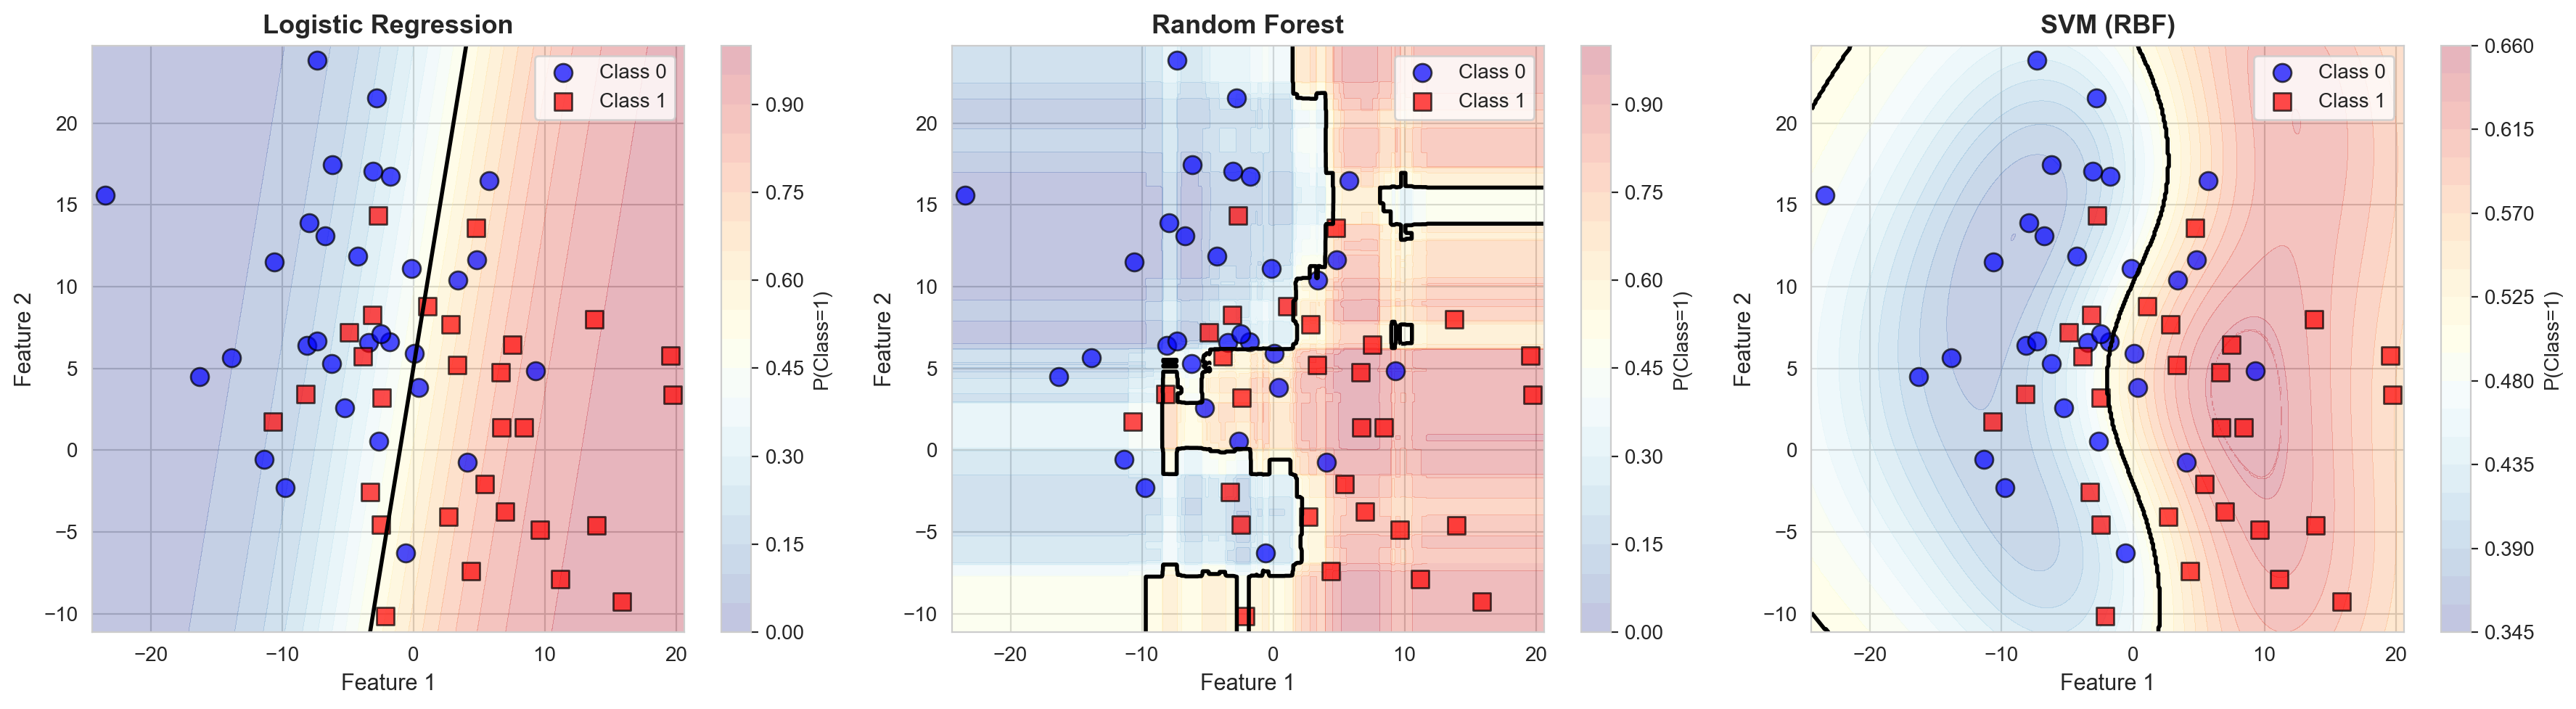

In [20]:
# Plot decision boundaries for all three models
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), 
                     np.arange(y_min, y_max, 0.1))

for ax, (name, model) in zip(axes, models.items()):
    # Get predictions
    Z = model.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    Z = Z.reshape(xx.shape)
    
    # Plot decision boundary
    contour = ax.contourf(xx, yy, Z, alpha=0.3, cmap='RdYlBu_r', levels=20)
    ax.contour(xx, yy, Z, levels=[0.5], colors='black', linewidths=2)
    
    # Plot test data
    ax.scatter(X_test[y_test == 0, 0], X_test[y_test == 0, 1], 
              marker='o', s=80, label='Class 0', color='blue', 
              edgecolors='k', alpha=0.7)
    ax.scatter(X_test[y_test == 1, 0], X_test[y_test == 1, 1], 
              marker='s', s=80, label='Class 1', color='red', 
              edgecolors='k', alpha=0.7)
    
    ax.set_title(f'{name}', fontsize=13, fontweight='bold')
    ax.set_xlabel('Feature 1', fontsize=11)
    ax.set_ylabel('Feature 2', fontsize=11)
    ax.legend(loc='best')
    
    # Add colorbar
    plt.colorbar(contour, ax=ax, label='P(Class=1)')

plt.tight_layout()
plt.show()

## 12. Key Takeaways

### Precision-Recall Curves:
- **Use when**: Classes are imbalanced, you care primarily about the positive class
- **AUC-PR**: Average Precision score
- **Interpretation**: Higher is better, perfect score = 1.0
- **Baseline**: Proportion of positive class

### ROC Curves:
- **Use when**: Classes are balanced, you care about both classes
- **AUC-ROC**: Area under ROC curve
- **Interpretation**: Higher is better, perfect score = 1.0, random = 0.5
- **Baseline**: Diagonal line (random classifier)

### Model Comparison:
- Always compare multiple metrics
- Context matters: different applications need different trade-offs
- Don't rely on a single number (accuracy, AUC, etc.)
- Visualize curves to understand trade-offs

### Practical Tips:
1. Start with accuracy for balanced data
2. Use PR curves for imbalanced data
3. Use ROC curves for general comparison
4. Always visualize your metrics
5. Choose threshold based on application needs

## 14. Final Comprehensive Comparison

In [ ]:
# Create comprehensive comparison table
comparison_results = []

for name, model in models.items():
    y_pred = model.predict(X_test)
    y_scores = model.predict_proba(X_test)[:, 1]
    
    acc = accuracy_score(y_test, y_pred)
    auc_roc = roc_auc_score(y_test, y_scores)
    auc_pr = average_precision_score(y_test, y_scores)
    
    # Get precision and recall at default threshold
    precision, recall, _, _ = confusion_metrics(model, X_test, y_test, threshold=0.5)
    
    comparison_results.append({
        'Model': name,
        'Accuracy': acc,
        'Precision': precision,
        'Recall': recall,
        'AUC-ROC': auc_roc,
        'AUC-PR': auc_pr
    })

comparison_df = pd.DataFrame(comparison_results)
comparison_df = comparison_df.sort_values('AUC-ROC', ascending=False).reset_index(drop=True)

print("\n" + "=" * 90)
print("COMPREHENSIVE MODEL COMPARISON")
print("=" * 90)
print(comparison_df.to_string(index=False))
print("=" * 90)
print("\nBest model by AUC-ROC:", comparison_df.iloc[0]['Model'])
print("Best model by AUC-PR:", comparison_df.sort_values('AUC-PR', ascending=False).iloc[0]['Model'])
print("=" * 90)